<h1>Keelelisuse identsifitseerimine</h1>

<h3>Vajalikud impordid</h3>

In [37]:
import os, os.path
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import math
import textwrap

from collections import Counter
from lingua import Language, LanguageDetectorBuilder, IsoCode639_1
from datasets import Dataset
from datetime import datetime
from collections import defaultdict
from tqdm import tqdm
from ftlangdetect import detect

<h3>Loeme andmed sisse</h3>

In [2]:
path = 'data/'
data = []

for file in os.listdir(path):
    filename = os.path.join(path, file)
    with open(filename, "r", encoding = 'utf-8') as fin:
        data.append(json.loads(fin.read()))

In [3]:
len(data)

44103

<h3>Vaatame, kui palju postitusi üldse tehtud on läbi aastate.</h3>

In [5]:
post_dates = []

for post in data:
    time = datetime.strptime(post["meta"]["created_utc"], '%Y-%m-%d %H:%M:%S')
    post_dates.append(time)

In [6]:
posts_per_year = defaultdict(int)
for post in post_dates:
    posts_per_year[post.year] += 1

sorted_data = sorted(posts_per_year.items())

years = [item[0] for item in sorted_data]
num_posts = [item[1] for item in sorted_data]

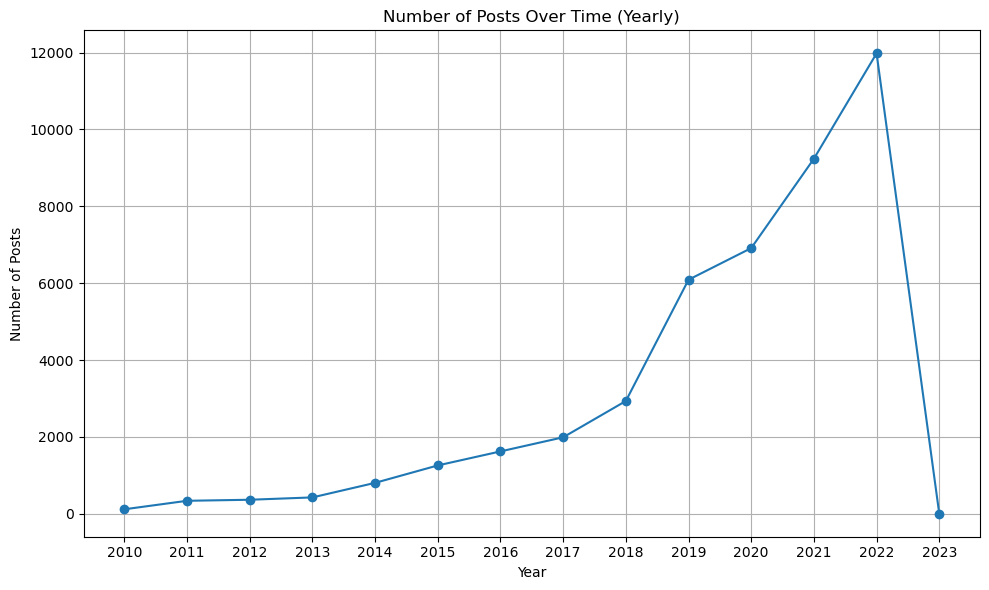

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(years, num_posts, marker='o', linestyle='-')

plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.title('Number of Posts Over Time (Yearly)')

plt.xticks(years)

plt.tight_layout()
plt.grid(True)
plt.show()

<h5>Kuna 2023 aastal on veider ilming, siis tundub, et seal on postitusi vähem, mistõttu vaatame, mis ajavahemikus on seal postitused tehtud ning vajadusel jätame 2023 vaatluse alt välja</h5>

In [8]:
posts_per_year

defaultdict(int,
            {2010: 119,
             2011: 340,
             2012: 367,
             2013: 428,
             2014: 807,
             2015: 1260,
             2016: 1625,
             2017: 1992,
             2018: 2936,
             2019: 6091,
             2020: 6914,
             2021: 9239,
             2022: 11981,
             2023: 4})

In [9]:
for post in data:
    created = post["meta"]["created_utc"]
    if created[:4] == "2023":
        print(created)

2023-01-01 00:00:01
2023-01-01 00:16:58
2023-01-01 00:24:40
2023-01-01 01:27:30


<h5>Kuna tegemist on 2023. aasta 4 esimese postitusega, ei ole mõistlik meil neid analüüsis arvestada, mistõttu eemaldame need andmestikust</h5>

In [10]:
to_be_deleted = []

for i in range(len(data)):
    created = data[i]["meta"]["created_utc"]
    if created[:4] == "2023":
        to_be_deleted.append(i)

In [11]:
to_be_deleted.sort(reverse=True)
to_be_deleted

[44102, 44101, 44100, 44099]

In [12]:
for i in to_be_deleted:
    del data[i]

In [13]:
for post in data:
    created = post["meta"]["created_utc"]
    if created[:4] == "2023":
        print(created)

<h3>Postituste arv läbi aastate</h3>

In [14]:
post_dates = []

for post in data:
    time = datetime.strptime(post["meta"]["created_utc"], '%Y-%m-%d %H:%M:%S')
    post_dates.append(time)

In [15]:
posts_per_year = defaultdict(int)
for post in post_dates:
    posts_per_year[post.year] += 1

sorted_data = sorted(posts_per_year.items())

years = [item[0] for item in sorted_data]
num_posts = [item[1] for item in sorted_data]

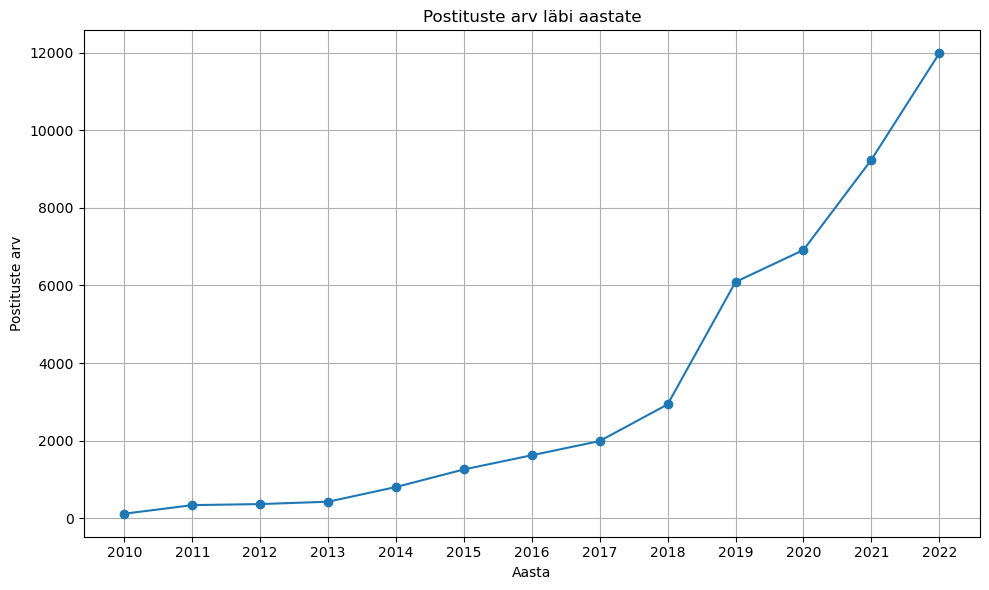

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(years, num_posts, marker='o', linestyle='-')

plt.xlabel('Aasta')
plt.ylabel('Postituste arv')
plt.title('Postituste arv läbi aastate')

plt.xticks(years)

plt.tight_layout()
plt.grid(True)
plt.show()

<h3>Vaatame, mis kellast on tavaliselt kombeks postitusi teha.</h3>

In [17]:
post_clock = []
post_weekday = []
nädalapäevad = ['Esmaspäev', 'Teisipäev', 'Kolmapäev', 'Neljapäev', 'Reede', 'Laupäev', 'Pühapäev']

for post in data:
    time = datetime.strptime(post["meta"]["created_utc"], '%Y-%m-%d %H:%M:%S')
    clock_time = time.strftime("%H:%M:%S")
    weekday_i = time.weekday()
    post_clock.append(clock_time)
    post_weekday.append(nädalapäevad[weekday_i])

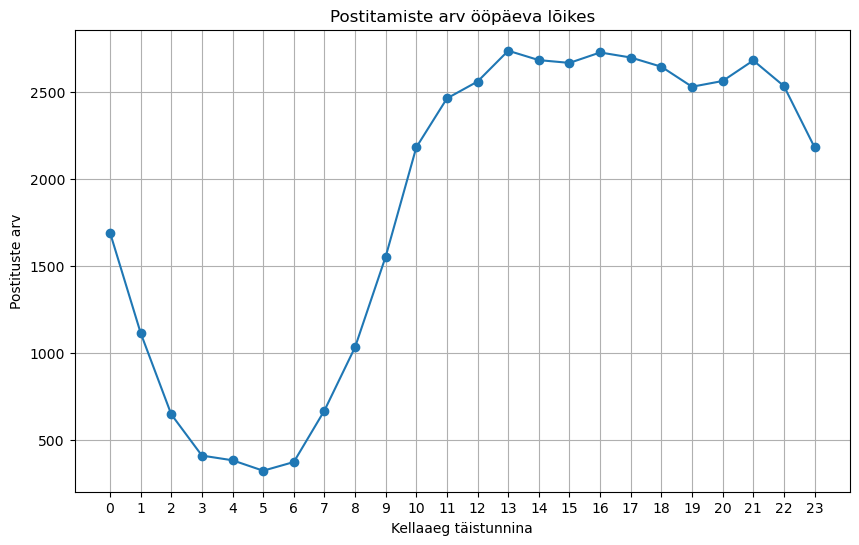

In [18]:
# Convert clock time strings to datetime objects
datetime_objects = [datetime.strptime(time_str, "%H:%M:%S") for time_str in post_clock]

df = pd.DataFrame({'Timestamp': datetime_objects})

# Extract hour component from datetime objects
df['Hour'] = df['Timestamp'].dt.hour

# Group by hour and count occurrences
hourly_counts = df.groupby('Hour').size()

# Plotting
plt.figure(figsize=(10, 6))
hourly_counts.plot(marker='o')
plt.xlabel('Kellaaeg täistunnina')
plt.ylabel('Postituste arv')
plt.title('Postitamiste arv ööpäeva lõikes')
plt.grid(True)
plt.xticks(range(24))
plt.show()

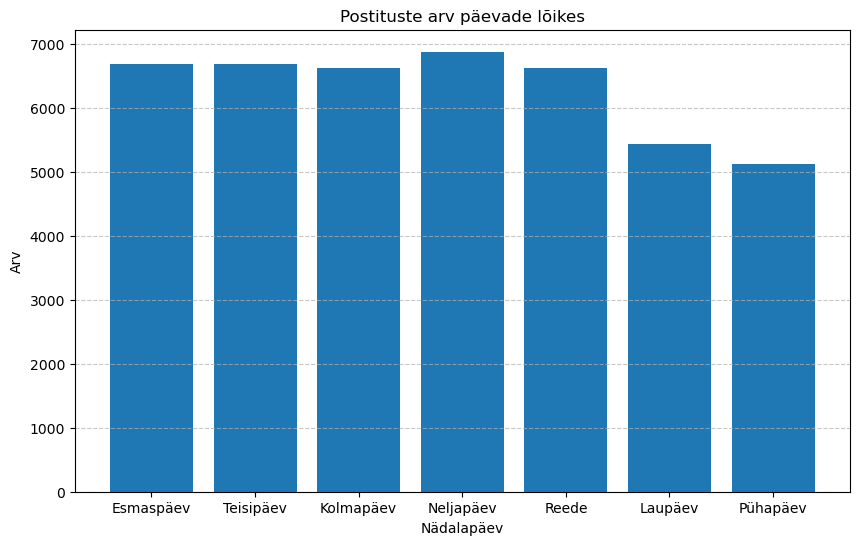

In [19]:
weekday_counts = Counter(post_weekday)

weekdays = list(weekday_counts.keys())
counts = list(weekday_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(nädalapäevad, [weekday_counts[nädalapäev] for nädalapäev in nädalapäevad])
plt.xlabel('Nädalapäev')
plt.xticks(nädalapäevad)
plt.ylabel('Arv')
plt.title('Postituste arv päevade lõikes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<h3>Andmete robustne liigitamine</h3>

In [20]:
videos = []
images = []
texts = []
text_id = []
links = []
polls = []
ülejääk = []

for i in data:
    if 'post_hint' in i['meta'] and i['meta']['post_hint'] == 'link':
        links.append(i)
    elif "poll_data" in i["meta"]:
        polls.append(i)
    elif 'post_hint' in i['meta'] and i['meta']['post_hint'] == 'image':
        images.append(i)
    elif 'post_hint' in i['meta'] and i['meta']['post_hint'] == 'rich:video':
        videos.append(i)   
    elif i['meta']['is_self'] == True:
        texts.append(i)
        text_id.append(i["meta"]["id"])
    elif 'is_video' in i['meta'] and i['meta']['is_video'] == True:
        videos.append(i)
    else:
        ülejääk.append(i)

In [21]:
ülejäänud_lingid = []
ülejäänud_pildid = []

for i in ülejääk:
    url = i["meta"]["url"]

    if url == None:
        ülejäänud_lingid.append(i)
    else:
        if url[-4:] == ".jpg":
            ülejäänud_pildid.append(i)
        elif url[-4:] == ".png":
            ülejäänud_pildid.append(i)
        else:
            ülejäänud_lingid.append(i)

In [22]:
images += ülejäänud_pildid
links += ülejäänud_lingid

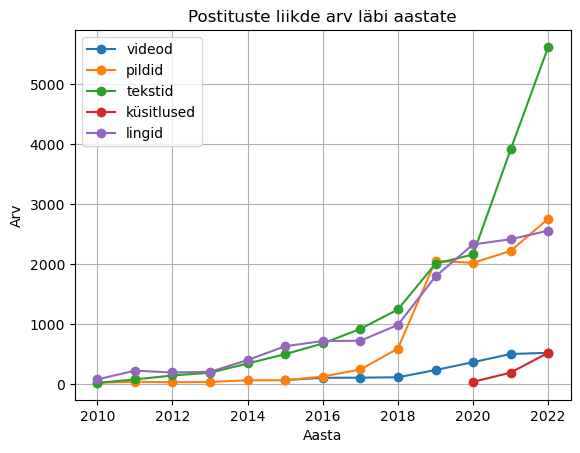

In [23]:
def plot_post_type(post_type_data, label):
    # võtan iga postituse seest välja aja, mil see loodi
    post_time = []
    for post in post_type_data:
        post_time.append(post["meta"]["created_utc"])

    # võtan välja ainult aastad 
    years = [datetime.strptime(ts, '%Y-%m-%d %H:%M:%S').year for ts in post_time]
    
    # loendan iga aasta
    yearly_counts = Counter(years)
    
    # sorteerin aastate järgi
    sorted_years = sorted(yearly_counts)
    counts = [yearly_counts[year] for year in sorted_years]
    
    plt.plot(sorted_years, counts, marker='o', linestyle='-', label=label)


plot_post_type(videos, "videod")
plot_post_type(images, "pildid")
plot_post_type(texts, "tekstid")
plot_post_type(polls, "küsitlused")
plot_post_type(links, "lingid")

plt.xlabel('Aasta')
plt.ylabel('Arv')
plt.title('Postituste liikde arv läbi aastate')
plt.grid(True)
plt.legend()
plt.show()

<h3>Uurime kui palju on kustutatud ja eemaldatud postitusi</h3>

In [24]:
deleted = []
removed = []
other = []

for i in data:
    text = i["text"]
    if text == "[removed]":
        removed.append(i)
    elif text == "[deleted]":
        deleted.append(i)
    else:
        other.append(i)

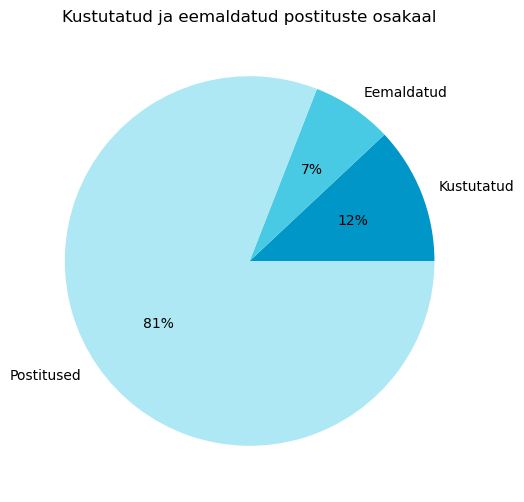

In [25]:
plt.figure(figsize=(12, 6))

pie_data = [len(deleted), len(removed), len(other)]

plt.pie(pie_data, labels = ["Kustutatud", "Eemaldatud", "Postitused"], colors = ["#0096c7", "#48cae4", "#ade8f4"], autopct='%1.0f%%')

plt.title('Kustutatud ja eemaldatud postituste osakaal')
plt.show() 

In [26]:
txt_len = []
for i in other:
    text = i['text'] + " " + i['meta']['title']
    text = text.replace('[deleted]', '')
    text = text.replace('[removed]', '')
    text = text.replace('[ Removed by Reddit ]', '')
    text = text.replace('[deleted by user]', '')
    
    if text != "" and text!=" ":
        txt_len.append(len(text))

print("Keskmine postituse pikkus pealkirjaga:", np.mean(txt_len))

Keskmine postituse pikkus pealkirjaga: 219.58346875875594


In [27]:
# KUI PALJU ON LÜHIKESI POSTITUSI < 100 sümbolit
lühikesed_postitused = 0

for i in other:
    text = i['text'] + " " + i['meta']['title']
    text = text.replace('[deleted]', '')
    text = text.replace('[removed]', '')
    text = text.replace('[ Removed by Reddit ]', '')
    text = text.replace('[deleted by user]', '')
    
    if text != "" and text!=" " and len(text) < 100:
        lühikesed_postitused += 1

print("Lühikesi postitusi on " + str(round(lühikesed_postitused/len(other)*100, 2)) + "% kõikidest postitustest.")

Lühikesi postitusi on 61.0% kõikidest postitustest.


<h5 style="color:red">Eemaldatud (<i>removed</i>) ja kustutatud (<i>deleted</i>) vahe on selles, et kustutatud postitused on kustutatud postituse postitanud kasutaja enda poolt, kuid eemeldatud postitused on maha võetud moderaatori või automaatsüsteemi poolt, sest see on rikkunud subredditi reegleid või Redditi saidipoliitikat.</h5>

In [28]:
deleted_comments = []
removed_comments = []
other_comments = []

for d in data:
    commentid = d["comments"]
    if len(commentid) != 0:
        for comment_data in commentid.values():
            text = comment_data["text"]
            if text == "[removed]":
                removed_comments.append(comment_data)
            elif text == "[deleted]":
                deleted_comments.append(comment_data)
            else:
                other_comments.append(comment_data)

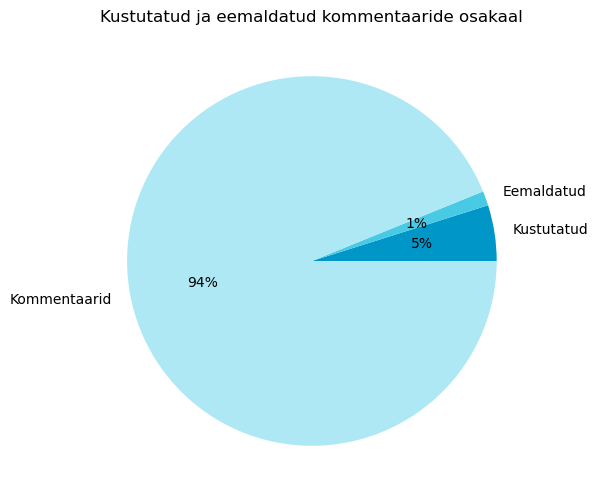

In [29]:
plt.figure(figsize=(12, 6))

pie_data = [len(deleted_comments), len(removed_comments), len(other_comments)]

plt.pie(pie_data, labels = ["Kustutatud", "Eemaldatud", "Kommentaarid"], colors = ["#0096c7", "#48cae4", "#ade8f4"], autopct='%1.0f%%')

plt.title('Kustutatud ja eemaldatud kommentaaride osakaal')
plt.show() 

In [65]:
txt_len = []
for i in other_comments:
    text = i['text']
    text = text.replace('[deleted]', '')
    text = text.replace('[removed]', '')
    text = text.replace('[ Removed by Reddit ]', '')
    text = text.replace('[deleted by user]', '')
    
    if text != "" and text!=" ":
        txt_len.append(len(text))

print("Keskmine kommentaari pikkus pealkirjaga:", np.mean(txt_len))

Keskmine kommentaari pikkus pealkirjaga: 224.68031847953327


In [30]:
# KUI PALJU ON LÜHIKESI KOMMENTAARE < 100 sümbolit
lühikesed_kommentaarid = 0
for i in other_comments:
    text = i['text']
    text = text.replace('[deleted]', '')
    text = text.replace('[removed]', '')
    text = text.replace('[ Removed by Reddit ]', '')
    text = text.replace('[deleted by user]', '')
    if len(text) < 100 and text != "" and text!=" ":
        lühikesed_kommentaarid += 1

print("Lühikesi kommentaare on " + str(round(lühikesed_kommentaarid/len(other_comments)*100, 2)) + "% kõikidest kommentaaridest.")

Lühikesi kommentaare on 47.94% kõikidest kommentaaridest.


<h3>Langdetect ning postituste- ja kommentaaride keelelisus</h3>

In [31]:
lang_posts = []
lang_posts_sisu = []
lang_posts_time = []
lang_posts_score = []

for post in texts:
    pealkiri = post["meta"]["title"].replace('\n', '')
    sisu = post["text"].replace('\n', '')
    sisu = pealkiri + " " + sisu
    sisu = sisu.replace("[deleted]", "")
    sisu = sisu.replace("[removed]", "")
    if sisu != '':# and sisu != '[deleted]' and sisu != '[removed]':
        detection = detect(text=sisu, low_memory=False)
        if detection["score"] < 0.3:
            lang_posts.append("unknown")
            lang_posts_score.append(detection["score"])
            lang_posts_sisu.append(sisu)
            lang_posts_time.append(post["meta"]["created_utc"])
        else:
            lang_posts.append(detection["lang"])
            lang_posts_score.append(detection["score"])
            lang_posts_sisu.append(sisu)
            lang_posts_time.append(post["meta"]["created_utc"])
        #if detection == "en":
        #    print(sisu)

In [32]:
lang_comments = []
lang_comments_sisu = []
lang_comments_time = []

for comment in data:
    try:
        puh_comments = [a["text"] for a in comment["comments"].values()]
        for com in puh_comments:
            sisu = com.replace('\n', '')
            if sisu != '' and sisu != '[deleted]' and sisu != '[removed]':
                detection = detect(text=sisu, low_memory=False)["lang"]
                lang_comments.append(detection)
                lang_comments_sisu.append(sisu)
                #if detection == "en":
                #    print(sisu)
    except:
        continue

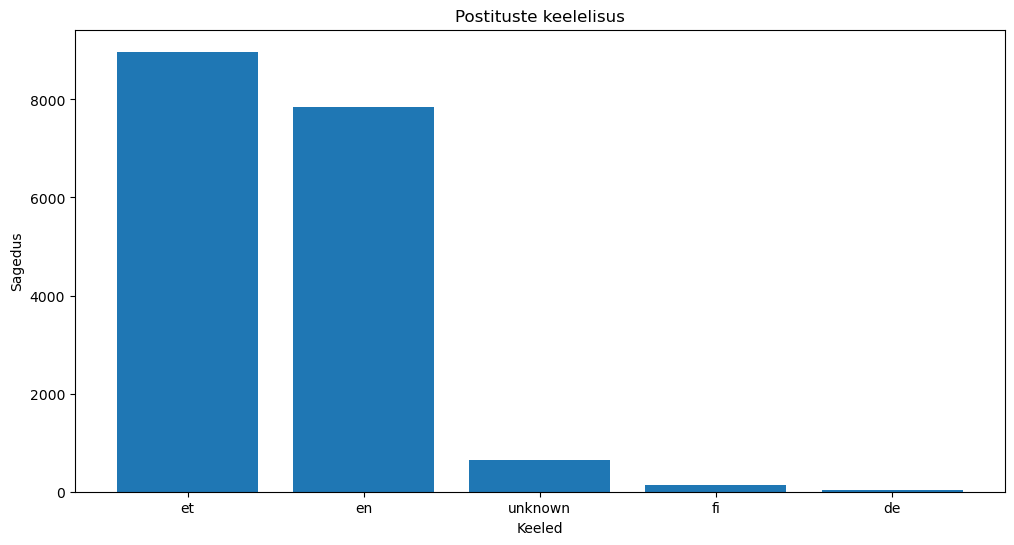

In [33]:
counter = Counter(lang_posts)

top_languages = counter.most_common(5)
labels = [item[0] for item in top_languages]
counts = [item[1] for item in top_languages]

plt.figure(figsize=(12, 6))
plt.bar(labels, counts)

plt.xlabel('Keeled')
plt.ylabel('Sagedus')
plt.title('Postituste keelelisus')

plt.show()

In [34]:
#lang_comments
#lang_comments_sisu

for i in range(len(lang_posts[1000])):
    if lang_comments[i] == "en":
        #print("kommentaari algus")
        print(lang_posts_sisu[i])
        print(lang_posts_score[i])
        print()
        #print("kommentaari lõpp")

I am looking for good resources for learning Estonian, help? I am attempting to learn Estonian, but I am having a hard time with noun tenses and when to use mulle and mina and such. Can any of you point me somewhere useful?
0.9383803009986877



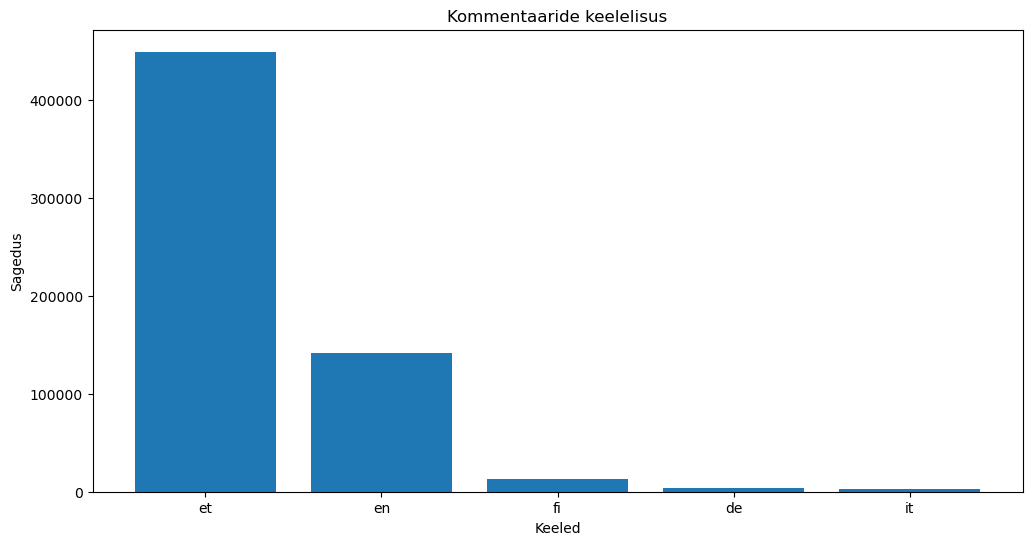

In [35]:
counter = Counter(lang_comments)

top_languages = counter.most_common(5)
labels = [item[0] for item in top_languages]
counts = [item[1] for item in top_languages]

plt.figure(figsize=(12, 6))
plt.bar(labels, counts)

plt.xlabel('Keeled')
plt.ylabel('Sagedus')
plt.title('Kommentaaride keelelisus')

plt.show()

<h3>Proovime nüüd üht teist keeletuvastuse mudelit <i>lingua</i></h3>

In [48]:
#languages = [Language.ENGLISH, Language.ESTONIAN, Language.GERMAN, Language.FINNISH]
detector = LanguageDetectorBuilder.from_all_spoken_languages().build()

In [49]:
lingua_posts = []
lingua_posts_sisu = []
lingua_posts_time = []
lingua_posts_score = []

for post in texts:
    pealkiri = post["meta"]["title"].replace('\n', '')
    sisu = post["text"].replace('\n', '')
    sisu = pealkiri + ". " + sisu
    sisu = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sisu)
    sisu = sisu.replace("[deleted]", "")
    #sisu = sisu.replace("[deleted by user]", "")
    sisu = sisu.replace("[removed]", "")
    sisu = sisu.replace('[deleted by user]', '')
    sisu = sisu.replace("&amp;#x200B;", "")
    sisu = sisu.replace("&gt;", ">")
    sisu = sisu.replace("&amp;", ">")
    
    if sisu != '':# and sisu != '[deleted]' and sisu != '[removed]':
        #detection = detector.detect_language_of(sisu)
        detection = detector.compute_language_confidence_values(sisu)[0]#.value#language.iso_code_639_1.name
        #print(detection)
        #print(sisu)
        if detection == None or detection.value < 0.69:
            lingua_posts.append("unknown")
        else:
            lingua_posts.append(detection.language.iso_code_639_1.name)
        #lingua_posts_score.append(detection["score"])
        lingua_posts_sisu.append(sisu)
        lingua_posts_time.append(post["meta"]["created_utc"])
        #if detection == "en":
        #    print(sisu)

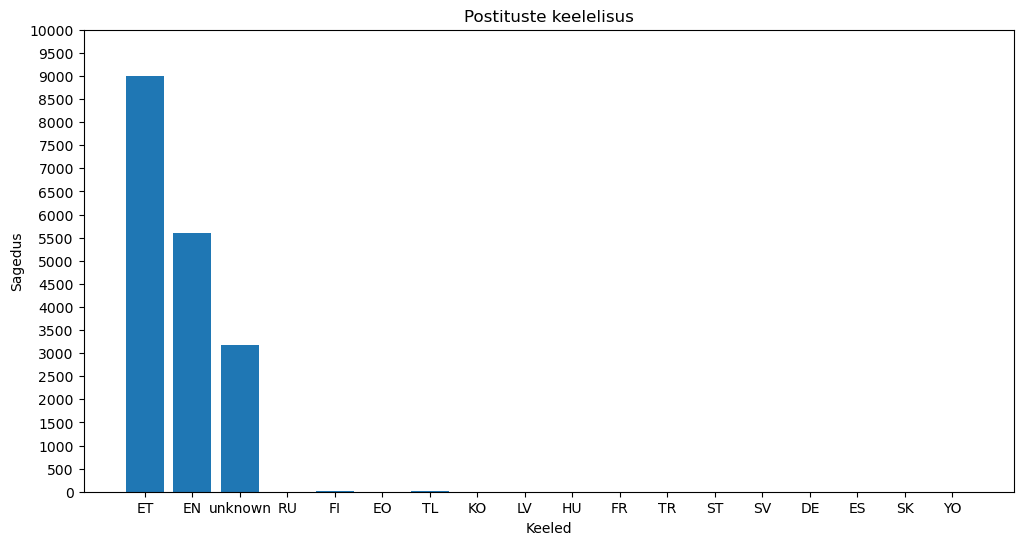

In [50]:
counter = Counter(lingua_posts)

#top_languages = counter.most_common(5)
#labels = [item[0] for item in top_languages]
#counts = [item[1] for item in top_languages]

labels = list(counter.keys())
counts = list(counter.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, counts)

plt.xlabel('Keeled')
plt.ylabel('Sagedus')
plt.yticks(range(0, max(counts)+1000, 500))
plt.title('Postituste keelelisus')

plt.show()

<h5>Käin huvipärast läbi kõik need keelte variandid ning vaatan, mis on nende sisuks, sest Lingual on võimalus anda ette keeled, mille vahel otsustamisel valik teha. Loodetavasti teeb see meie andmestiku puhtamaks.</h5>

In [41]:
# Sisse võivad jääda: ET, EN, ES, SV, HU, FA, LV, TR, FR, KO, NO, RU
for i in range(len(lingua_posts)):
    if lingua_posts[i] == "NB":
        print(lingua_posts_sisu[i])

In [60]:
detector = LanguageDetectorBuilder.from_iso_codes_639_1(IsoCode639_1.ET, IsoCode639_1.EN, IsoCode639_1.ES, IsoCode639_1.SV, IsoCode639_1.HU, IsoCode639_1.FA, IsoCode639_1.LV, IsoCode639_1.TR, IsoCode639_1.FR, IsoCode639_1.KO, IsoCode639_1.NB, IsoCode639_1.RU).build()

In [61]:
print(len(texts))
print(len(text_id))

17813
17813


In [62]:
lingua_posts = []
lingua_posts_sisu = []
lingua_posts_time = []
lingua_posts_score = []
terve_postitus = []
texts_lang = []

for i in range(len(texts)):
    post = texts[i]
    pealkiri = post["meta"]["title"].replace('\n', '')
    sisu = post["text"].replace('\n', '')
    sisu = pealkiri + ". " + sisu
    sisu = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sisu)
    sisu = sisu.replace("[deleted]", "")
    sisu = sisu.replace("[deleted by user]", "")
    sisu = sisu.replace("[removed]", "")
    sisu = sisu.replace("&amp;#x200B;", "")
    sisu = sisu.replace("&gt;", ">")
    sisu = sisu.replace("&amp;", ">")
    
    if sisu != '' and sisu != ' ':# and sisu != '[deleted]' and sisu != '[removed]':
        #detection = detector.detect_language_of(sisu)
        detection = detector.compute_language_confidence_values(sisu)[0]#.value#language.iso_code_639_1.name
        #print(detection)
        #print(sisu)
        if detection == None or detection.value < 0.69:
            lingua_posts.append("unknown")
            #texts_lang.append("unknown")
        else:
            lingua_posts.append(detection.language.iso_code_639_1.name)
            #texts_lang.append(detection.language.iso_code_639_1.name)

    else:
        #texts_lang.append("unknown")
        lingua_posts.append("unknown")

    lingua_posts_sisu.append(sisu)
    lingua_posts_time.append(post["meta"]["created_utc"])
    terve_postitus.append(post)

In [63]:
print(len(lingua_posts))

17813


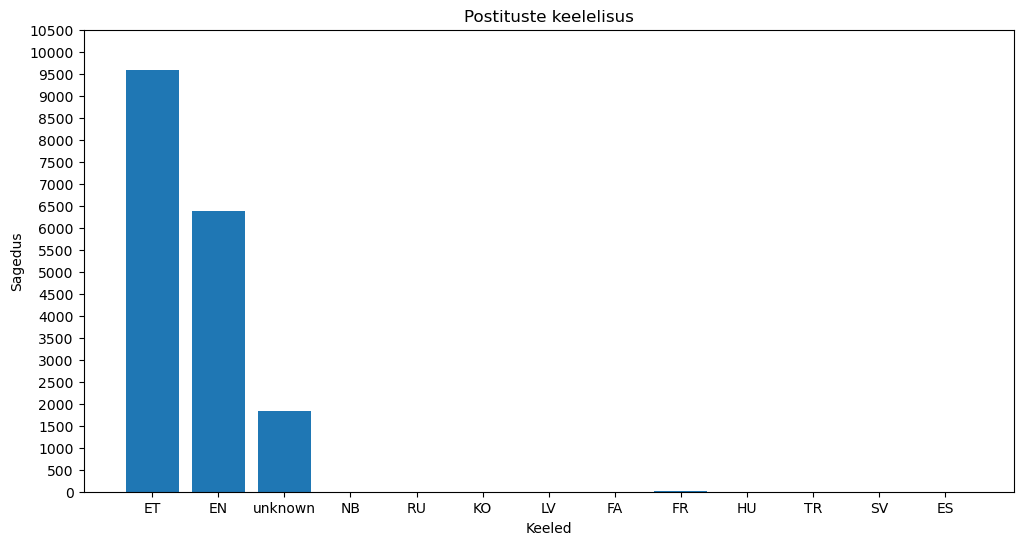

In [64]:
counter = Counter(lingua_posts)

#top_languages = counter.most_common(5)
#labels = [item[0] for item in top_languages]
#counts = [item[1] for item in top_languages]

labels = list(counter.keys())
counts = list(counter.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, counts)

plt.xlabel('Keeled')
plt.ylabel('Sagedus')
plt.yticks(range(0, max(counts)+1000, 500))
plt.title('Postituste keelelisus')

plt.show()

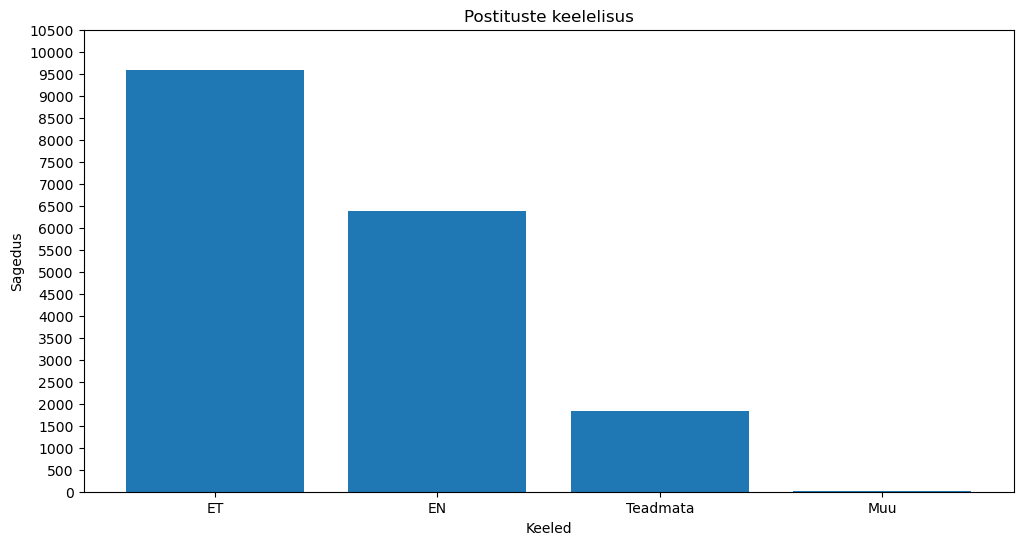

In [65]:
labels_cleaned = []
counts_cleaned = []
lang_other_posts = []

for i in counter.keys():
    if i not in ["ET", "EN", "unknown"]:
        lang_other_posts.append(counter[i])
    else:
        labels_cleaned.append(i)
        counts_cleaned.append(counter[i])

labels_cleaned.append("Muu")
labels_cleaned[2] = "Teadmata"
counts_cleaned.append(sum(lang_other_posts))

plt.figure(figsize=(12, 6))
plt.bar(labels_cleaned, counts_cleaned)

plt.xlabel('Keeled')
plt.ylabel('Sagedus')
plt.yticks(range(0, max(counts)+1000, 500))
plt.title('Postituste keelelisus')

plt.show()

In [66]:
df = pd.DataFrame.from_dict(counter, orient='index', columns=['Count'])

df = df.sort_values(by='Count', ascending=False)
df = df.rename_axis('Label', axis=0)

df

,Count
Label,
ET,9576
EN,6369
unknown,1841
FR,7
RU,5
SV,4
LV,3
NB,2
ES,2


In [28]:
unknown_posts_sisu = []

for i in range(len(lingua_posts)):
    if lingua_posts[i] == "unknown":
        unknown_posts_sisu.append(lingua_posts_sisu[i])

file = open("lingua_output.txt", "w", encoding='utf-8')
for i in unknown_posts_sisu:
    result = detector.detect_multiple_languages_of(i)

    file.write("Text: " + i + "\n")
    file.write("Label:" + str([label.language for label in result]) + "\n")#[0].language.iso_code_639_1.name)
    file.write(str(detector.compute_language_confidence_values(i)) + "\n")
    file.write("\n")

file.close()

In [95]:
stacked_dict = dict()
stacked_dict["tag"] = []
stacked_dict["year"] = []

for i in range(len(lingua_posts)):
    tag = lingua_posts[i]
    if tag == "EN" or tag == "ET" or tag == "unknown":
        stacked_dict["tag"].append(tag)
    else:
        stacked_dict["tag"].append("other")
    stacked_dict["year"].append(lingua_posts_time[i][:4])

In [96]:
cross_tab_prop = pd.crosstab(index=stacked_dict['year'],
                             columns=stacked_dict['tag'],
                             normalize="index")

In [97]:
cross_tab_prop = cross_tab_prop.rename(columns={"other": "Muu", "unknown": "Teadmata"})

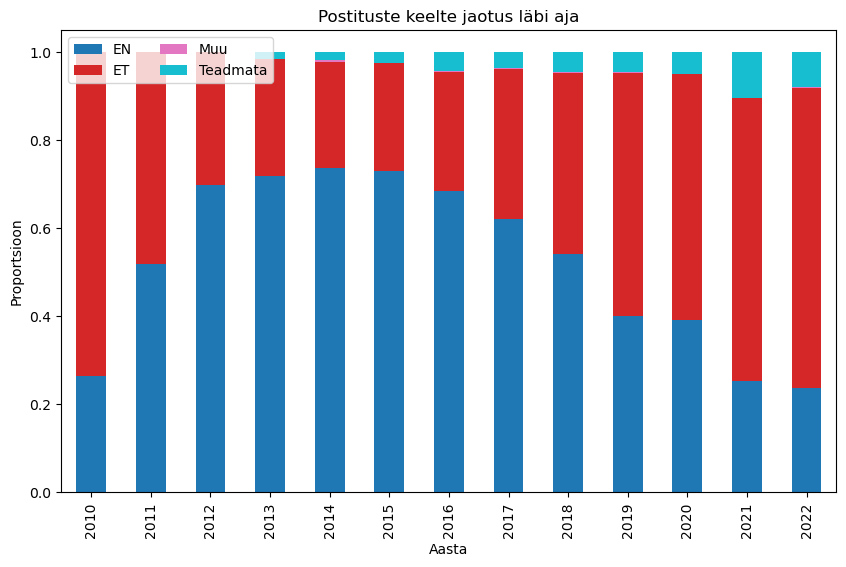

In [98]:
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Aasta")
plt.ylabel("Proportsioon")
plt.title('Postituste keelte jaotus läbi aja')
plt.show()

<h3>Teeme kommentaaridele keeletuvastust</h3>

In [67]:
detector = LanguageDetectorBuilder.from_all_spoken_languages().build()

In [68]:
### VÕTAN AINULT NEED KOMMENTAARID, MILLE TEKSTE ENNE ANALÜÜSISIN NING MIS LÄBISID FILTRI - ehk siis postitus pole kustutatud ega eemaldatud
lingua_comments = []
lingua_comments_sisu = []
lingua_comments_time = []

for i in terve_postitus:
    kommentaarid = i["comments"]
    if kommentaarid != []:
        for j in list(kommentaarid.values()):
            sisu = j["text"]

            sisu = sisu.replace('\n', '')
            sisu = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sisu)
            sisu = sisu.replace("[deleted]", "")
            sisu = sisu.replace("[deleted by user]", "")
            sisu = sisu.replace("[removed]", "")
            sisu = sisu.replace("&amp;#x200B;", "")
            sisu = sisu.replace("&gt;", ">")
            sisu = sisu.replace("&amp;", ">")
            
            if sisu != '' and sisu != ' ':# and sisu != '[deleted]' and sisu != '[removed]':
                detection = detector.compute_language_confidence_values(sisu)[0]#.value#language.iso_code_639_1.name

            if detection == None or detection.value < 0.69:
                lingua_comments.append("unknown")
            else:
                lingua_comments.append(detection.language.iso_code_639_1.name)
            
            lingua_comments_sisu.append(sisu)
            lingua_comments_time.append(j["meta"]["created_utc"])

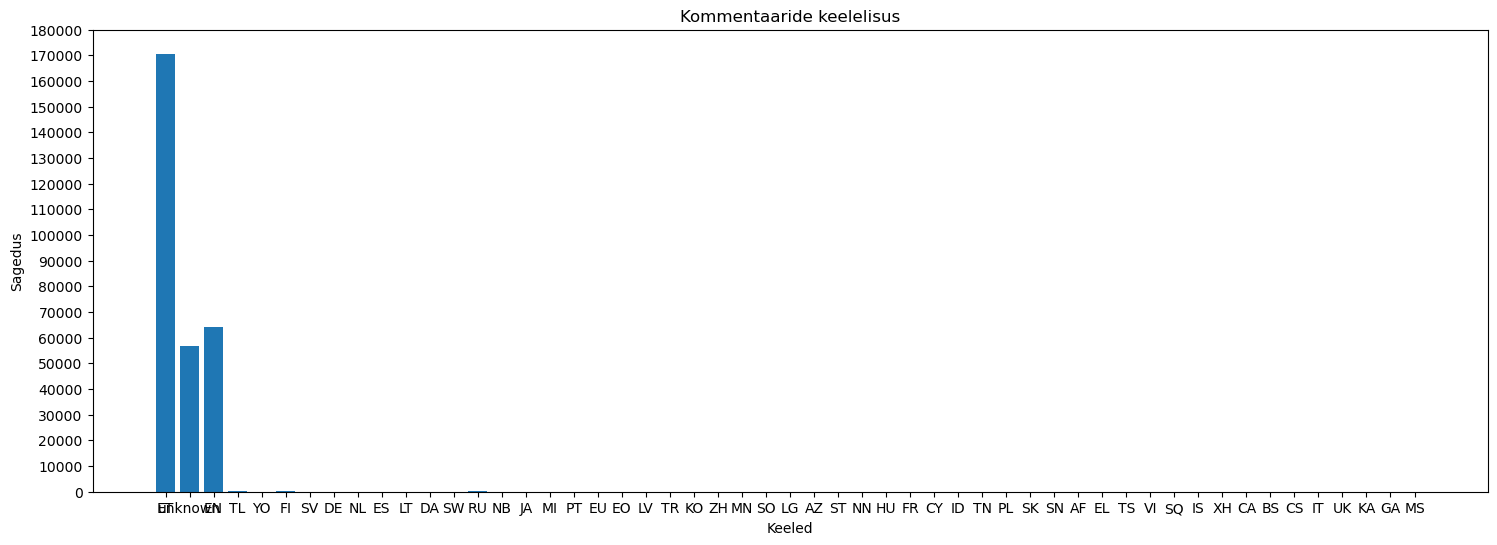

In [69]:
counter = Counter(lingua_comments)

#top_languages = counter.most_common(5)
#labels = [item[0] for item in top_languages]
#counts = [item[1] for item in top_languages]

labels = list(counter.keys())
counts = list(counter.values())

plt.figure(figsize=(18, 6))
plt.bar(labels, counts)

plt.xlabel('Keeled')
plt.ylabel('Sagedus')
plt.yticks(range(0, max(counts)+10000, 10000))
plt.title('Kommentaaride keelelisus')

plt.show()

In [70]:
#lingua_comments
#lingua_comments_sisu
# SISSE JÄTA ET, EN, FI, SV, DE, NL, ES, LT, DA, NB, JA, PT, LV, TR, KO, ZH, HU, FR, PL, EL, CS, IT, UK, KA
for i in range(len(lingua_comments)):
    if lingua_comments[i] == "MS":
        print(lingua_comments_sisu[i])

Nahhujnada xd


In [71]:
detector = LanguageDetectorBuilder.from_iso_codes_639_1(IsoCode639_1.ET, IsoCode639_1.ET, IsoCode639_1.EN, IsoCode639_1.FI, IsoCode639_1.SV, IsoCode639_1.DE, IsoCode639_1.NL, IsoCode639_1.ES, IsoCode639_1.LT, IsoCode639_1.DA, IsoCode639_1.NB, IsoCode639_1.JA, IsoCode639_1.PT, IsoCode639_1.LV, IsoCode639_1.TR, IsoCode639_1.KO, IsoCode639_1.ZH, IsoCode639_1.HU, IsoCode639_1.FR, IsoCode639_1.PL, IsoCode639_1.EL, IsoCode639_1.CS, IsoCode639_1.IT, IsoCode639_1.UK, IsoCode639_1.KA).build()

In [72]:
lingua_comments = []
lingua_comments_sisu = []
lingua_comments_time = []
lingua_comments_id = []

for i in terve_postitus:
    kommentaarid = i["comments"]
    if kommentaarid != []:
        for key, value in kommentaarid.items():
            # KUNA ME VAATAME AINULT KUNI 2022 OLEVAID ANDMEID, PEAKSIME SIIT KA KÕIK 2023 ANDMED ÄRA JÄTMA
            sisu = value["text"]
    
            sisu = sisu.replace('\n', '')
            sisu = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sisu)
            sisu = sisu.replace("[deleted]", "")
            sisu = sisu.replace("[deleted by user]", "")
            sisu = sisu.replace("[removed]", "")
            sisu = sisu.replace("&amp;#x200B;", "")
            sisu = sisu.replace("&gt;", ">")
            sisu = sisu.replace("&amp;", ">")
                
            if sisu != '' and sisu != ' ':# and sisu != '[deleted]' and sisu != '[removed]':
                detection = detector.compute_language_confidence_values(sisu)[0]#.value#language.iso_code_639_1.name
    
                if detection == None or detection.value < 0.69:
                    lingua_comments.append("unknown")
                else:
                    lingua_comments.append(detection.language.iso_code_639_1.name)

            else:
                lingua_comments.append("unknown")
                
            lingua_comments_sisu.append(sisu)
            lingua_comments_time.append(value["meta"]["created_utc"])
            lingua_comments_id.append(key)

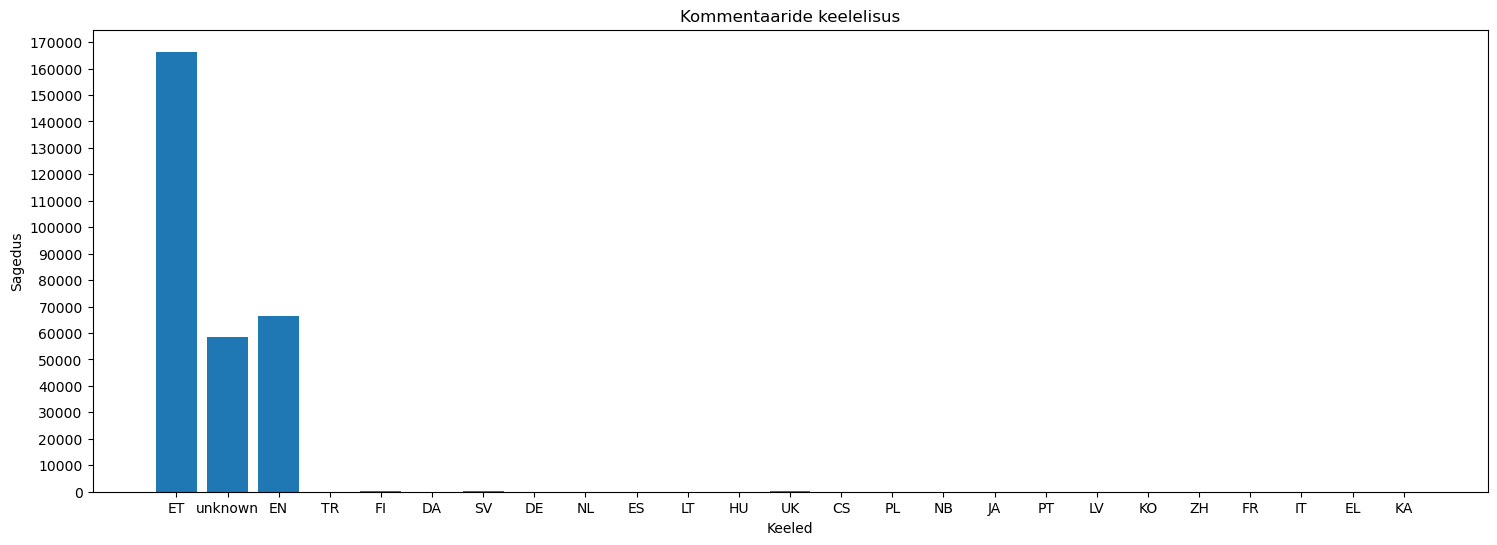

In [73]:
counter = Counter(lingua_comments)

#top_languages = counter.most_common(5)
#labels = [item[0] for item in top_languages]
#counts = [item[1] for item in top_languages]

labels = list(counter.keys())
counts = list(counter.values())

plt.figure(figsize=(18, 6))
plt.bar(labels, counts)

plt.xlabel('Keeled')
plt.ylabel('Sagedus')
plt.yticks(range(0, max(counts)+10000, 10000))
plt.title('Kommentaaride keelelisus')

plt.show()

In [74]:
df_com = pd.DataFrame.from_dict(counter, orient='index', columns=['Count'])

df_com = df_com.sort_values(by='Count', ascending=False)
df_com = df_com.rename_axis('Label', axis=0)

df_com

,Count
Label,
ET,166366
EN,66574
unknown,58545
FI,324
UK,125
SV,95
TR,49
ES,39
DE,28


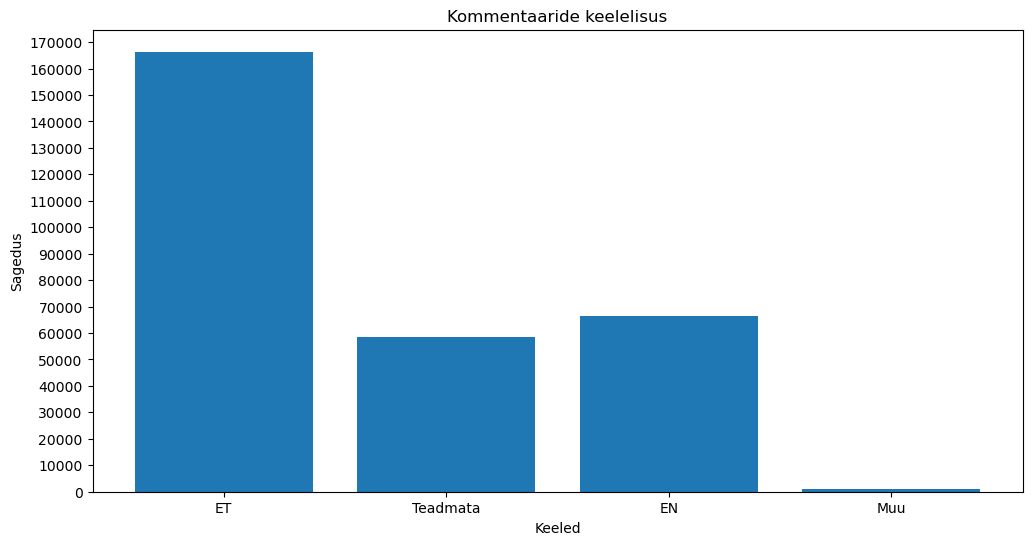

In [103]:
labels_cleaned_coms = []
counts_cleaned_coms = []
lang_other_coms = []

for i in counter.keys():
    if i not in ["ET", "EN", "unknown"]:
        lang_other_coms.append(counter[i])
    else:
        labels_cleaned_coms.append(i)
        counts_cleaned_coms.append(counter[i])

labels_cleaned_coms.append("Muu")
labels_cleaned_coms[1] = "Teadmata"
counts_cleaned_coms.append(sum(lang_other_coms))

plt.figure(figsize=(12, 6))
plt.bar(labels_cleaned_coms, counts_cleaned_coms)

plt.xlabel('Keeled')
plt.ylabel('Sagedus')
plt.yticks(range(0, max(counts)+10000, 10000))
plt.title('Kommentaaride keelelisus')

plt.show()

In [39]:
print(len(lingua_comments))
print(len(lingua_comments_sisu))

292387
292387


In [40]:
unknown_comments_sisu = []

for i in range(len(lingua_comments)):
    if lingua_comments[i] == "unknown":
        unknown_comments_sisu.append(lingua_comments_sisu[i])

file = open("lingua_comments_output.txt", "w", encoding='utf-8')
for i in unknown_comments_sisu:
    result = detector.detect_multiple_languages_of(i)

    file.write("Text: " + i + "\n")
    file.write("Label:" + str([label.language for label in result]) + "\n")#[0].language.iso_code_639_1.name)
    file.write(str(detector.compute_language_confidence_values(i)) + "\n")
    file.write("\n")

file.close()

In [104]:
stacked_dict = dict()
stacked_dict["tag"] = []
stacked_dict["year"] = []

for i in range(len(lingua_comments)):
    tag = lingua_comments[i]
    if lingua_comments_time[i][:4] != "2023":
        if tag == "EN" or tag == "ET" or tag == "unknown":
            stacked_dict["tag"].append(tag)
        else:
            stacked_dict["tag"].append("other")
        stacked_dict["year"].append(lingua_comments_time[i][:4])

In [105]:
cross_tab_prop = pd.crosstab(index=stacked_dict['year'],
                             columns=stacked_dict['tag'],
                             normalize="index")

In [106]:
cross_tab_prop = cross_tab_prop.rename(columns={"other": "Muu", "unknown": "Teadmata"})

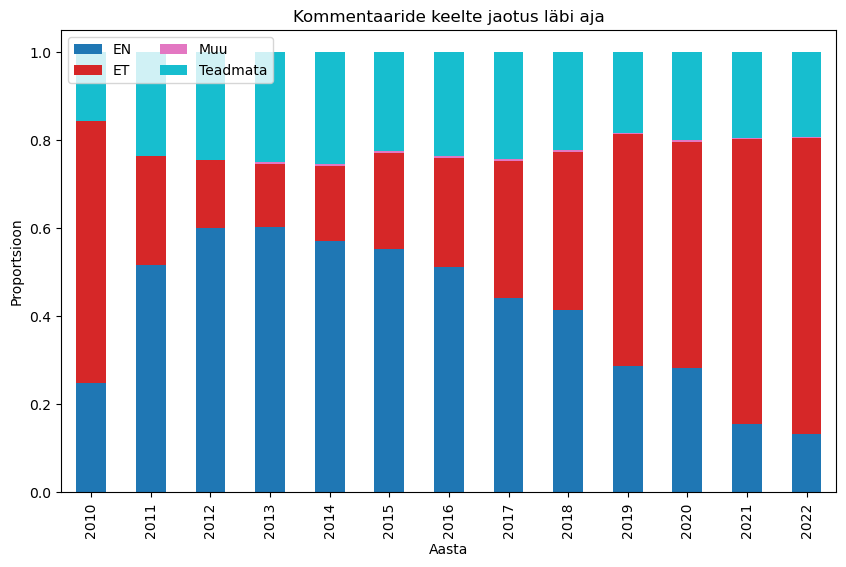

In [108]:
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Aasta")
plt.ylabel("Proportsioon")
plt.title('Kommentaaride keelte jaotus läbi aja')
plt.show()

<h3>Loome algoritmi, et kui postituse keel on unknown, aga kõik postituse all olevad kommentaarid (või enamus kommentaare?) on sama lävendi alusel ühes kindlas keeles, siis omistada ka postitusele see keel.</h3>

<h5>Enne andmetel rakendamist kontrollime, kui täpselt selline lähenemine suudab toimida. Selle jaoks võtame välja kõik tuvastatud keeled ning vaatame kommentaaride järgi, kui palju me sedasi tehes eksime</h5> 

In [73]:
tulemused = []

for i in tqdm(range(len(terve_postitus))):
    # vaatame vaid neid postitusi, mille keele suutsime eelnevalt tuvastada
    if lingua_posts[i] != "unknown":
        comments = terve_postitus[i]["comments"]
        if len(comments) != 0:
            keeled = []
            #print(comments.keys())
            for comment_id in comments.keys():
                for j in range(len(lingua_comments_id)):
                    if comment_id == lingua_comments_id[j]:
                        keeled.append(lingua_comments[j])
                        
            if len(keeled) == 2 and keeled[0] != keeled[1]:
                continue
            elif len(keeled) == 1:
                continue
            else:
                keeled_counter = Counter(keeled)
                populaarseim = keeled_counter.most_common(1)[0][0]
                if populaarseim == lingua_posts[i]:
                    tulemused.append(1)
                else:
                    tulemused.append(0)

100%|█████████████████████████████████████████████████████████████████████████| 17813/17813 [12:43:51<00:00,  2.57s/it]


In [74]:
tulemused_acc = (tulemused.count(1) / len(tulemused)) * 100
print('Algoritmi täpsus (accuracy): ' + str(round(tulemused_acc, 2)) + "%")

Algoritmi täpsus (accuracy): 88.93%


<h5>Rakendame seda nüüd andmete peal</h5>

In [75]:
#len(terve_postitus)
#len(lingua_posts)
#lingua_comments_id
for i in tqdm(range(len(terve_postitus))):
    if lingua_posts[i] == "unknown":
        comments = terve_postitus[i]["comments"]
        if len(comments) != 0:
            keeled = []
            #print(comments.keys())
            for comment_id in comments.keys():
                for j in range(len(lingua_comments_id)):
                    if comment_id == lingua_comments_id[j]:
                        keeled.append(lingua_comments[j])
                        
            if len(keeled) == 2 and keeled[0] != keeled[1]:
                continue
            elif len(keeled) == 1:
                continue
            else:
                keeled_counter = Counter(keeled)
                populaarseim = keeled_counter.most_common(1)[0][0]
                lingua_posts[i] = populaarseim

            #print(populaarseim)
            #print(lingua_posts_sisu[i])
            #print(comments.values())
            #print()

100%|████████████████████████████████████████████████████████████████████████████| 17813/17813 [13:34<00:00, 21.87it/s]


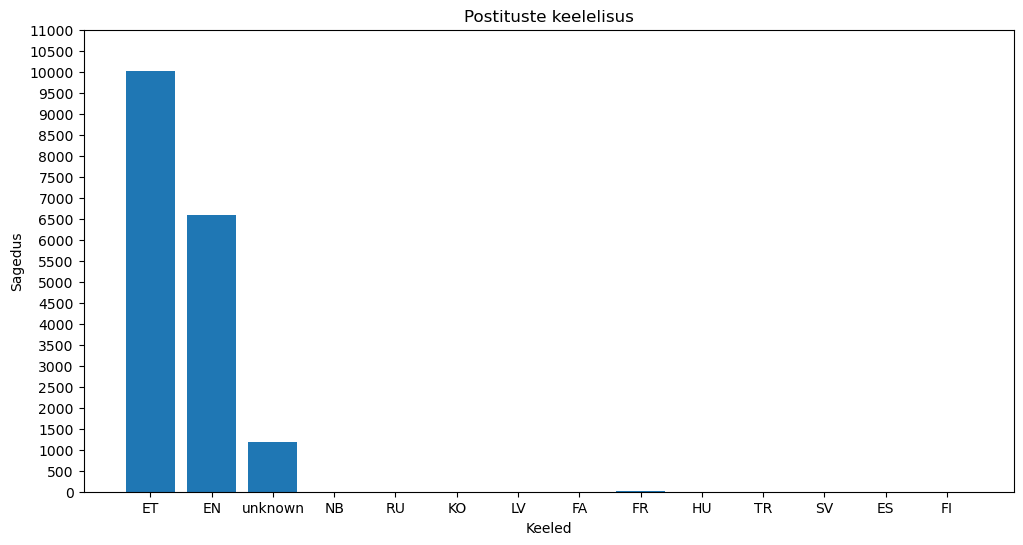

In [76]:
counter = Counter(lingua_posts)

#top_languages = counter.most_common(5)
#labels = [item[0] for item in top_languages]
#counts = [item[1] for item in top_languages]

labels = list(counter.keys())
counts = list(counter.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, counts)

plt.xlabel('Keeled')
plt.ylabel('Sagedus')
plt.yticks(range(0, max(counts)+1000, 500))
plt.title('Postituste keelelisus')

plt.show()

In [ ]:
labels_cleaned = []
counts_cleaned = []
lang_other_posts = []

for i in counter.keys():
    if i not in ["ET", "EN", "unknown"]:
        lang_other_posts.append(counter[i])
    else:
        labels_cleaned.append(i)
        counts_cleaned.append(counter[i])

labels_cleaned.append("Muu")
labels_cleaned[2] = "Teadmata"
counts_cleaned.append(sum(lang_other_posts))

plt.figure(figsize=(12, 6))
plt.bar(labels_cleaned, counts_cleaned)

plt.xlabel('Keeled')
plt.ylabel('Sagedus')
plt.yticks(range(0, max(counts)+1000, 500))
plt.title('Postituste keelelisus')

plt.show()

In [77]:
df = pd.DataFrame.from_dict(counter, orient='index', columns=['Count'])

df = df.sort_values(by='Count', ascending=False)
df = df.rename_axis('Label', axis=0)

df

,Count
Label,
ET,10012
EN,6581
unknown,1192
FR,7
RU,5
SV,4
LV,3
NB,2
ES,2


<h5>Kirjutame keeletuvastuse tulemused andmestikku, mida kasutada hiljem teemade analüüsi osas</h5>

In [78]:
data_copy = data.copy()
title_string = '''data_lang/Eesti_'''